In [1]:
%matplotlib notebook
import os, sys
import logging
import random
import h5py
import shutil
import time
import argparse
import numpy as np
import sigpy.plot as pl
import torch
import sigpy as sp
import torchvision
from torch import optim
from tensorboardX import SummaryWriter
from torch.nn import functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib
# import custom libraries
from utils import transforms as T
from utils import subsample as ss
from utils import complex_utils as cplx
from utils.resnet2p1d import generate_model
from utils.flare_utils import roll
from utils import data_ut as dut
# import custom classes
from utils.datasets import SliceData
from subsample_fastmri import MaskFunc
from MoDL_single import UnrolledModel
import argparse
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
from models.SAmodel import MyNetwork
from models.Unrolled import Unrolled
from ImageFusion_Dualbranch_Fusion.densefuse_net import DenseFuseNet
from ImageFusion_Dualbranch_Fusion.channel_fusion import channel_f as channel_fusion

from RCAN import CombinedNetwork
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
%load_ext autoreload
%autoreload 0

In [2]:
!pwd

/home/tal/docker/MoDLsinglechannel/modl_singlechannel_reference


In [3]:
!which python3

/home/tal/docker/dockvenv/bin/python3


In [4]:

# Path to your NIfTI file
nii_file_target = './test_data/patient29b/T1_week152reg.nii'
img_target = nib.load(nii_file_target)
nii_file_ref = './test_data/patient29b/T1_week165regT1_week152.nii'
img_ref = nib.load(nii_file_ref)
target = img_target.get_fdata()[...,20]
reference = img_ref.get_fdata()[...,20]

random_phase = torch.angle(T.random_map((1,256,160), 'cpu',kspace_radius_range=(0.001, 0.001))) 
target = target * (torch.exp(1j * random_phase)).numpy() 
target = target.squeeze(0)
target_torch = cplx.to_tensor(target).float() 
reference_torch = cplx.to_tensor(reference).float() 
reference_kspace_torch = T.fft2(reference_torch)
reference_kspace = cplx.to_numpy(reference_kspace_torch)
#reference_kspace_torch = T.kspace_cut(reference_kspace_torch, 0.67,0.67)
#reference_kspace = cplx.to_numpy(reference_kspace_torch)
#reference_torch = T.ifft2(reference_kspace_torch)
#reference = cplx.to_numpy(reference_torch)
kspace_torch = T.fft2(target_torch)
#kspace_torch = T.kspace_cut(kspace_torch, 0.67,0.67)
#target_torch = T.ifft2(kspace_torch)
target = cplx.to_numpy(target_torch)
kspace = cplx.to_numpy(kspace_torch)
# Print the shape of the data to verify
print(target_torch.shape)
mask2 = sp.mri.poisson((256,160),5, calib=(18,14), dtype=float, crop_corner=False, return_density=True, seed=0, max_attempts=6, tol=0.01)
mask2[128-10:128+9,80-8:80+7] = 1
mask_torch = torch.stack([torch.tensor(mask2).float(),torch.tensor(mask2).float()],dim=2)

mask_torch = T.kspace_crop(mask_torch,0.67)
kspace_torch = T.awgn_torch(kspace_torch,10,L=1)
kspace_torch = T.kspace_crop(kspace_torch,0.67)

print(kspace_torch.shape)
print(mask_torch.shape)
kspace_torch = kspace_torch*mask_torch

s = (256/1.5)*(160/1.5)
print((torch.sum(mask_torch))/s)


torch.Size([256, 160, 2])
torch.Size([256, 160, 2])
torch.Size([256, 160, 2])
tensor(0.6423)


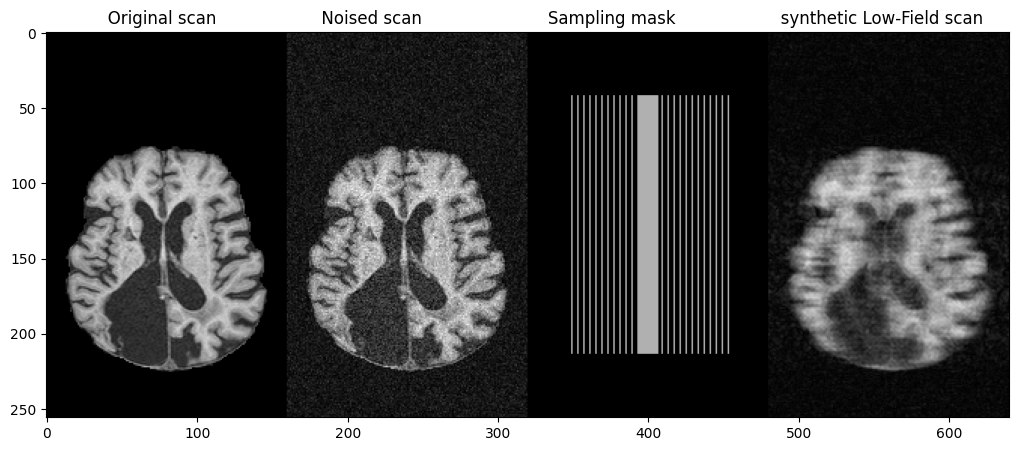

Mask torch size: (256, 160)
Acceleration factor R: 0.621484375


In [5]:
im_lowres = abs(sp.ifft(sp.resize(sp.resize(kspace,(256,24)),(256,160))))
magnitude_vals = im_lowres.reshape(-1)
k = int(round(0.05 * magnitude_vals.shape[0]))
scale = magnitude_vals[magnitude_vals.argsort()[::-1][k]]
kspace = kspace/scale
target = target/scale
# Convert everything from numpy arrays to tensors
kspace_torch = cplx.to_tensor(kspace).float()
kspace_torch = T.awgn_torch(kspace_torch,10,L=1)
kspace_noised = kspace_torch.clone()
kspace_torch = T.kspace_crop(kspace_torch,0.67)
target_torch = cplx.to_tensor(target).float()

### Reference addition ###
im_lowres_ref = abs(sp.ifft(sp.resize(sp.resize(reference_kspace,(256,24)),(256,160))))
magnitude_vals_ref = im_lowres_ref.reshape(-1)
k_ref = int(round(0.05 * magnitude_vals_ref.shape[0]))
scale_ref = magnitude_vals_ref[magnitude_vals_ref.argsort()[::-1][k_ref]]
reference = reference / scale_ref
reference_torch = cplx.to_tensor(reference).float()

"""
fig, axs = plt.subplots(1, 1, figsize=(5, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs.imshow(np.abs(cplx.to_numpy(mask_torch)), cmap='gray')
plt.show()
"""
#kspace_torch = kspace_torch*mask_torch

from fastmri.data import transforms, subsample
def get_mask_func(factor):
    center_fractions = 0.08 * 4/factor
    mask_func = subsample.EquiSpacedMaskFunc(
    center_fractions=[center_fractions],
    accelerations=[factor], 
    )
    return mask_func
mask_func = get_mask_func(4)
kspace_torch = transforms.apply_mask(kspace_torch, mask_func)[0]

concat = np.concatenate((target,cplx.to_numpy(T.ifft2(kspace_noised)),np.abs(cplx.to_numpy(kspace_torch))!=0,cplx.to_numpy(T.ifft2(kspace_torch))),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(20, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs.imshow(np.abs(concat), cmap='gray')
#im1 = axs.imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')
plt.title('       Original scan                    Noised scan                        Sampling mask                    synthetic Low-Field scan')
plt.show()

mask_np = np.abs(cplx.to_numpy(kspace_torch))!=0
print(f'Mask torch size: {mask_np.shape}')
s = (256/2)*(160/2)
print(f'Acceleration factor R: {np.sum(mask_np)/s}')

In [6]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [7]:
#Hyper parameters
params = Namespace()
#params.data_path = "./registered_data/patient23b/"
params.data_path = "./registered_data/"
params.batch_size = 2
params.num_grad_steps = 1 #4
params.num_cg_steps = 8 #8
params.share_weights = True
params.modl_lamda = 0.05
params.lr = 0.00001
#params.lr = 0.0001
params.weight_decay = 0
params.lr_step_size = 7
params.lr_gamma = 0.1
params.epoch = 61
params.reference_mode = 1
params.reference_lambda = 0.1

In [9]:

#3checkpoint_file = "./L2_checkpoints_poisson_x2_SAunrolledPlug/model_5.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x2_UnrolledFusionNetViT/model_15.pt"  # 35 - is good one
#checkpoint_file = "./L2_checkpoints_poisson_x2_UnrolledFusionNetViT_finetune/model_15.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x2_UnrolledFusionNetViT_finetuneall/model_20.pt"
checkpoint_file = "./L2_checkpoints_poisson_x2_UnrolledFusionNetViT_finetuneTests/model_5.pt"
checkpoint = torch.load(checkpoint_file,map_location=device)
# Init model
from vision_transformer import VisionTransformer
from recon_net import ReconNet

from UnrolledViT import UnrolledViT
model = UnrolledViT(params).to(device)

# load checkpoint
#cp = torch.load('./lsdir-2x+hq50k_vit_epoch_60.pt', map_location=device)
#checkpoint_file = "./L2_checkpoints_poisson_x2_FusionNetViT/model_30.pt"
model.load_state_dict(checkpoint['model'])


FileNotFoundError: [Errno 2] No such file or directory: './L2_checkpoints_poisson_x2_UnrolledFusionNetViT_finetuneTests/model_10.pt'

torch.Size([1, 1, 256, 160])
Current value of param2 during forward: Parameter containing:
tensor([ 7.4338e-03,  5.3211e-04,  1.4265e-02,  2.2924e-02,  1.1234e-02,
         1.1822e-02,  6.7485e-03,  7.7955e-03,  1.7508e-02, -1.0081e-02,
         4.4043e-03,  1.4257e-02,  1.2398e-02,  1.6531e-02,  7.6132e-04,
         2.3432e-03, -1.6882e-03, -1.0006e-02,  6.3099e-03,  1.5967e-02,
         2.4740e-03,  3.2602e-03, -4.9266e-03, -6.5658e-03,  1.1682e-02,
        -1.6263e-02, -8.0548e-03,  6.9317e-03,  4.4122e-03,  8.7271e-03,
        -1.0577e-02, -9.5441e-03, -9.3417e-03, -1.4451e-02,  8.2037e-04,
         1.3642e-02, -4.7528e-03, -4.2031e-03, -1.0107e-02, -9.6119e-03,
         7.3554e-03, -2.1196e-02, -1.3716e-02,  7.6466e-05, -3.6173e-03,
         3.0452e-03, -1.3902e-02, -1.4699e-02, -7.5792e-03, -1.1873e-02,
         3.7404e-03,  1.6182e-02,  9.9983e-04,  1.1811e-03, -3.5261e-03,
        -3.3135e-03,  1.0493e-02, -1.6000e-02, -9.8037e-03,  4.6477e-03,
         2.5089e-03,  5.7728e-03,

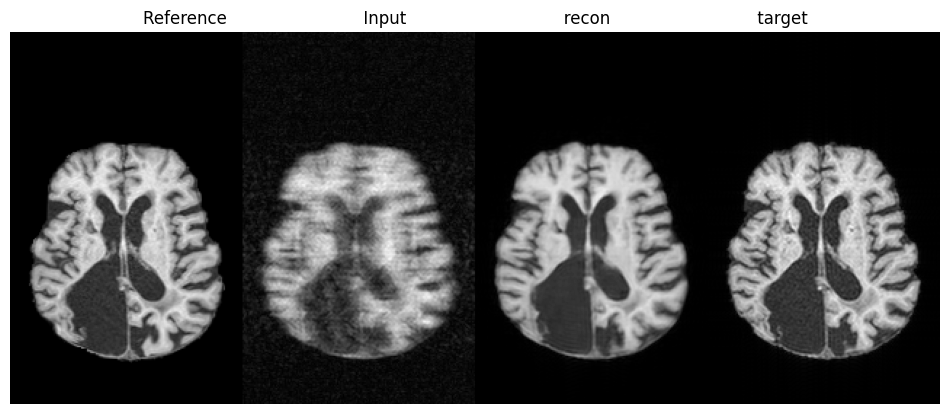

In [ ]:


img = cplx.to_tensor(np.abs(cplx.to_numpy(T.ifft2(kspace_torch)))).permute(2,0,1).unsqueeze(0).to(device)
img_chan = img[:,0,:,:].unsqueeze(0)
ref = cplx.to_tensor(np.abs(cplx.to_numpy(reference_torch))).permute(2,0,1).unsqueeze(0).to(device)
ref_chan = ref[:,0,:,:].unsqueeze(0)
ref_np = ref_chan.cpu().numpy()[0,0,:,:]
print(img_chan.shape)
img_padded_np = img_chan.cpu().numpy()[0,0,:,:]
"""
output = model(img_chan.float())

#vgg_features = model.encoder(input)
print(output.shape)
#print(vgg_features.shape)
ref_np = ref_chan.cpu().numpy()[0,0,:,:]
img_padded_np = img_chan.cpu().numpy()[0,0,:,:]
output_np = output.cpu().detach().numpy()[0,0,:,:]

# Norm
in_pad, wpad, hpad = model.pad(img_chan)
ref_pad, wpad, hpad = model.pad(ref_chan)
input_norm,mean,std = model.norm(in_pad.float())
ref_norm,mean_ref,std_ref = model.norm(ref_pad.float())
# Feature extract
features = model.net.forward_features(input_norm)
features_ref = model.net.forward_features(ref_norm)
features_comb = (7*features + 3*features_ref)/10

# Recon Head
head_out = model.net.head(features_comb) 
head_out_img = model.net.seq2img(head_out, (260, 160))

# un-norm
merged = model.unnorm(head_out_img, mean, std) 

# un-pad 
im_out = model.unpad(merged,wpad,hpad)
"""
im_out = model(kspace_torch.float().unsqueeze(0).to(device),reference_torch.float().unsqueeze(0).to(device)).squeeze(0)
print(im_out.shape)
im_out_pad = torch.cat((im_out,torch.zeros_like(im_out)),dim=2)
print(im_out_pad.shape)
im_out = T.ifft2(T.kspace_crop(T.fft2(im_out_pad),0.67))
target_torch = T.ifft2(T.kspace_crop(T.fft2(cplx.to_tensor(target)),0.67))
target = cplx.to_numpy(target_torch.cpu().detach())
#merged_np = im_out.cpu().detach().numpy()[0,:,:,:]
#im_out = np.sqrt(merged_np[:,:,0]**2 + merged_np[:,:,1]**2)
im_out = np.abs(cplx.to_numpy(im_out.cpu().detach()))
#im_out = 1-(np.abs(im_out)-np.abs(target))
print(im_out.shape)
"""
print(f'features_comb shape: {features_comb.shape}')
print(f'head_out shape: {head_out.shape}')
print(f'merged shape: {merged.shape}')
print(f'output_np shape: {output_np.shape}')
print(f'ref_np shape: {ref_np.shape}')
print(f'img_padded_np shape: {img_padded_np.shape}')
print(f'target shape: {target.shape}')
print(f'features shape: {features.shape}')
"""
# Concatenate images horizontally
concatenated_image = np.concatenate((ref_np,img_padded_np, im_out,np.abs(target)),axis=1)
# Plot the concatenated image
plt.figure(figsize=(12, 6))
plt.imshow(concatenated_image, cmap='gray')
plt.title('Reference                          Input                              recon                            target')
plt.axis('off')
plt.show()


In [ ]:
kspace_torch.shape
reference_torch.shape

torch.Size([256, 160, 2])

(256, 160)


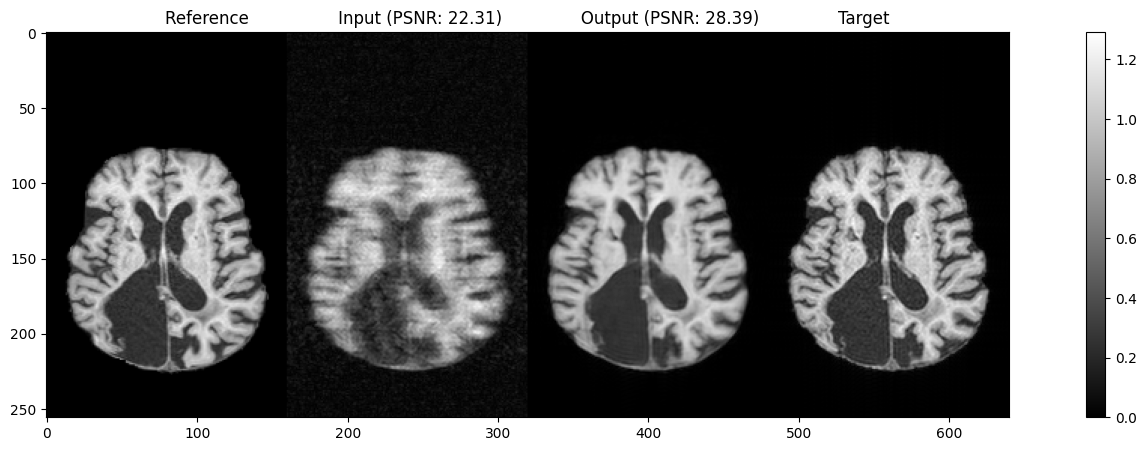

In [ ]:

def compute_psnr(img1, img2, maxval):
    """Computes PSNR in dB"""
    mse = np.mean((img1 - img2) ** 2)

    return (10 * np.log10(maxval / mse)).item()
cplx_image_target = target
cplx_image_in = img_padded_np
cplx_image_out = im_out

cplx_image_reference = ref_np
maxval = np.max(np.abs(np.concatenate((cplx_image_target,cplx_image_in,cplx_image_out),axis=0)))

psnr_in = compute_psnr(np.abs(cplx_image_target)/maxval, np.abs(cplx_image_in)/maxval,1)
psnr_out = compute_psnr(np.abs(cplx_image_target)/maxval,np.abs(cplx_image_out)/maxval,1)

"""
# Create a figure and axes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs[0].imshow(np.flipud(np.abs(cplx_image_in)), cmap='gray')
axs[0].set_title('Input')
fig.colorbar(im1, ax=axs[0])
im2 = axs[1].imshow(np.flipud(np.abs(cplx_image_out)), cmap='gray')
axs[1].set_title('Output')
fig.colorbar(im2, ax=axs[1])
im3 = axs[2].imshow(np.flipud(np.abs(cplx_image_target)), cmap='gray')
axs[2].set_title('Target')
fig.colorbar(im3, ax=axs[2])
plt.tight_layout()
plt.show()
"""
print(cplx_image_out.shape)
plt_concat = np.concatenate((np.abs(cplx_image_reference),np.abs(cplx_image_in),np.abs(cplx_image_out),np.abs(cplx_image_target)),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(20, 5))  # 1 row, 3 columns
im = axs.imshow(plt_concat, cmap='gray')
axs.set_title(f'Reference                 Input (PSNR: {psnr_in:.2f})               Output (PSNR: {psnr_out:.2f})               Target')
#axs.set_title(f'Reference                         Input                         Output                                 Target')
fig.colorbar(im, ax=axs)
plt.show()




(256, 160)
(256, 160)
(256, 160)


/tmp/ipykernel_1587765/566286739.py:11: RuntimeWarning: divide by zero encountered in log
  im = axs.imshow(np.log(np.abs(plt_concat)), cmap='gray')


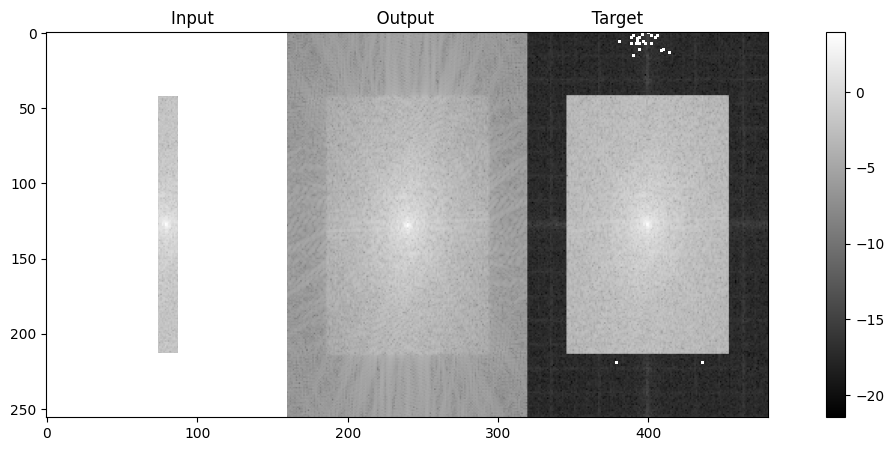

/tmp/ipykernel_1587765/566286739.py:16: RuntimeWarning: divide by zero encountered in log
  pl.ImagePlot(np.log(np.abs(plt_concat).astype(float)))
/home/tal/.local/lib/python3.10/site-packages/matplotlib/image.py:453: RuntimeWarning: invalid value encountered in double_scalars
  vmid = np.float64(self.norm.vmin) + dv / 2


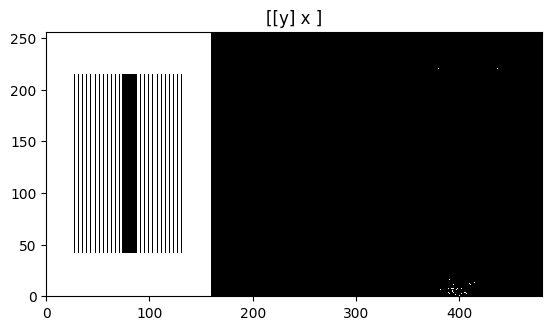

In [ ]:

print(cplx_image_target.shape)
print(cplx_image_in.shape)
print(cplx_image_out.shape)
# Create a figure and axes
kspace_in = cplx.to_numpy(kspace_torch)
kspace_out = cplx.to_numpy(T.fft2((cplx.to_tensor(cplx_image_out))))
kspace_target = cplx.to_numpy(T.fft2((cplx.to_tensor(cplx_image_target))))

plt_concat = np.concatenate((kspace_in,kspace_out,kspace_target),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(15, 5))  # 1 row, 3 columns
im = axs.imshow(np.log(np.abs(plt_concat)), cmap='gray')
axs.set_title('Input                               Output                              Target')
fig.colorbar(im, ax=axs)
plt.show()

pl.ImagePlot(np.log(np.abs(plt_concat).astype(float)))

In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage import img_as_float

####### Errors calculation #######

# Assuming img1 and img2 are PIL images or numpy arrays
# Convert PIL images to numpy arrays if needed
img_target = img_as_float(np.abs(cplx_image_target).copy())/np.max(np.abs(cplx_image_target))
img_in = img_as_float(np.abs(cplx_image_in)/np.max(cplx_image_in))/np.max(np.abs(cplx_image_in))
img_out = img_as_float(np.abs(cplx_image_out).copy())/np.max(np.abs(cplx_image_out))
img_reference = img_as_float(np.abs(cplx_image_reference).copy())/np.max(np.abs(cplx_image_reference))

####### Errors calculation #######

print(f'MSE input: {np.mean(np.abs(cplx_image_in-cplx_image_target)**2)}')
print(f'MSE output: {np.mean(np.abs(cplx_image_out-cplx_image_target)**2)}')

print(f'PSNR input: {T.PSNR(target_torch.cpu(), T.ifft2(kspace_torch.cpu()))}')
print(f'PSNR output: {T.PSNR(target_torch.cpu(), im_out.cpu().unsqueeze(0))}')

# Calculate SSIM values
data_range = img_target.max() - img_target.min()
#ssim_in, _ = ssim(img_target, img_in, data_range=data_range, full=True)
#ssim_out, _ = ssim(img_target, img_out, data_range=data_range, full=True)
cplx_im_out = cplx.to_numpy(im_out.cpu())
image_out = np.abs(cplx_im_out) / np.max(np.abs(cplx_im_out))
cplx_im_in = cplx.to_numpy( T.ifft2(kspace_torch.cpu()))
im_in = np.abs(cplx_im_in).squeeze(0) / np.max(np.abs(cplx_im_in))
cplx_im_target = cplx.to_numpy( target_torch.cpu())
im_target = np.abs(cplx_im_target) / np.max(np.abs(cplx_im_target))
data_range = im_target.max() - im_target.min()

print(im_target.shape)
print(im_in.shape)
ssim_in, _ = ssim(im_target, im_in, data_range=data_range, full=True)
ssim_out, _ = ssim(im_target, image_out, data_range=data_range, full=True)

print(f"SSIM input: {ssim_in:.4f}")
print(f"SSIM output: {ssim_out:.4f}")


MSE input: 0.589113309108952
MSE output: 0.5972024202346802


IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 3)